In [2]:
import torch
import numpy as np
from PIL import Image
from copy import deepcopy
from time import time
import os
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
from tqdm import tqdm
import anndata

In [3]:
data_path = "./hest1k_datasets/her2st/processed_data/"  # processed data path
ori_st_path = "./hest1k_datasets/her2st/st/" # original ST data path

slide_out = "SPA152"

# load training slide IDs
slidename_lst = list(np.genfromtxt(data_path + "all_slide_lst.txt", dtype=str))
slidename_lst.remove(slide_out)
print(slide_out, " is held out for testing ", (slide_out not in slidename_lst))

# load selected gene list
selected_genes = list(np.genfromtxt(data_path + "selected_gene_list.txt", dtype=str))
print("Selected gene list loaded. len of selected genes: ", len(selected_genes))

# load test slide
test_adata = anndata.read_h5ad(ori_st_path + slide_out + ".h5ad")
test_count_mtx_df = pd.DataFrame(test_adata.X, columns=test_adata.var_names, index=test_adata.obs_names).loc[:, selected_genes]
# transform count
test_count_mtx_selected_genes = np.log2(test_count_mtx_df + 1).copy()
print("Test count mtx shape: ", test_count_mtx_selected_genes.shape)

# load generated samples for test slide
sample_path = "her2st_results/runs/005/samples/generated_samples_0001450_sample.pt"  # (example)
pred = torch.load(sample_path, )
pred = pred.squeeze(1)
print("Generated samples shape: ", pred.shape)

SPA152  is held out for testing  True
Selected gene list loaded. len of selected genes:  300
Test count mtx shape:  (359, 300)
Generated samples shape:  torch.Size([359, 300])


C:\Users\Administrator\AppData\Local\Temp\ipykernel_15792\2888698982.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pred = torch.load(sample_path, )


In [4]:
num_rep = 1       # number of samples generated for one image patch
num_selected = 1  # take average of (a subset / all) samples and use it as prediction
random_selected_index = np.random.choice(np.arange(num_rep), num_selected, replace=False)

pred_avg = torch.zeros(size=(test_count_mtx_selected_genes.shape[0], 
                             test_count_mtx_selected_genes.shape[1]))
for i in range(test_count_mtx_selected_genes.shape[0]):
    pred_avg[i] = torch.mean(pred[i*num_rep + random_selected_index, :], dim=0)

pred_avg = pred_avg.cpu().detach().numpy()

(array([ 3.,  0.,  2.,  2.,  1.,  3.,  5.,  3.,  6.,  8., 11., 15.,  5.,
        10., 17., 22., 11., 16.,  5., 14., 15., 13.,  8.,  8.,  9.,  9.,
        11., 12., 11.,  5.,  7.,  5.,  9.,  2.,  3.,  1.,  5.,  2.,  1.,
         2.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([-4.95785806e-02, -3.70690394e-02, -2.45594982e-02, -1.20499570e-02,
         4.59584205e-04,  1.29691254e-02,  2.54786666e-02,  3.79882078e-02,
         5.04977490e-02,  6.30072902e-02,  7.55168314e-02,  8.80263726e-02,
         1.00535914e-01,  1.13045455e-01,  1.25554996e-01,  1.38064537e-01,
         1.50574079e-01,  1.63083620e-01,  1.75593161e-01,  1.88102702e-01,
         2.00612243e-01,  2.13121785e-01,  2.25631326e-01,  2.38140867e-01,
         2.50650408e-01,  2.63159950e-01,  2.75669491e-01,  2.88179032e-01,
         3.00688573e-01,  3.13198114e-01,  3.25707656e-01,  3.38217197e-01,
         3.50726738e-01,  3.63236279e-01,  3.75745820e-01,  3.88255362e-01,
         4.00764903e-01,  4.1327

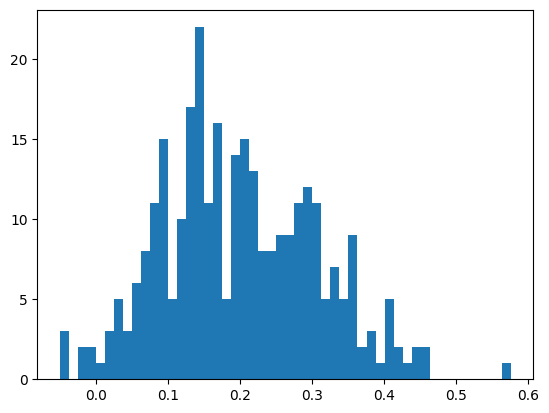

In [5]:
# calculate correlation

all_corr = []
for i in range(test_count_mtx_selected_genes.shape[1]):
    x = test_count_mtx_selected_genes.iloc[:, i].values
    y = pred_avg[:, i]
    cor = np.corrcoef(x, y)[0][1]
    all_corr.append(cor)
plt.hist(all_corr, bins=50)

Evaluation metrics

In [6]:
# evaluation metrics

# PCC
print("PCC-10: ", np.mean(sorted(all_corr)[::-1][:10]))
print("PCC-50: ", np.mean(sorted(all_corr)[::-1][:50]))
print("PCC-300: ", np.mean(sorted(all_corr)[::-1][:200]))
# MSE, MAE
print("MSE: ", np.mean((test_count_mtx_selected_genes.values - pred_avg)**2))
print("MAE: ", np.mean(np.abs(test_count_mtx_selected_genes.values - pred_avg)))
# RVD
pred_var = np.var(pred_avg, axis=0)
gt_var = np.var(test_count_mtx_selected_genes.values, axis=0)
print("RVD: ", np.mean((pred_var - gt_var)**2 / gt_var**2))

PCC-10:  0.44651175885752875
PCC-50:  0.36755129526288566
PCC-300:  0.2565417410842487
MSE:  1.269584990807746
MAE:  0.8549825737412519
RVD:  0.09288309728232455


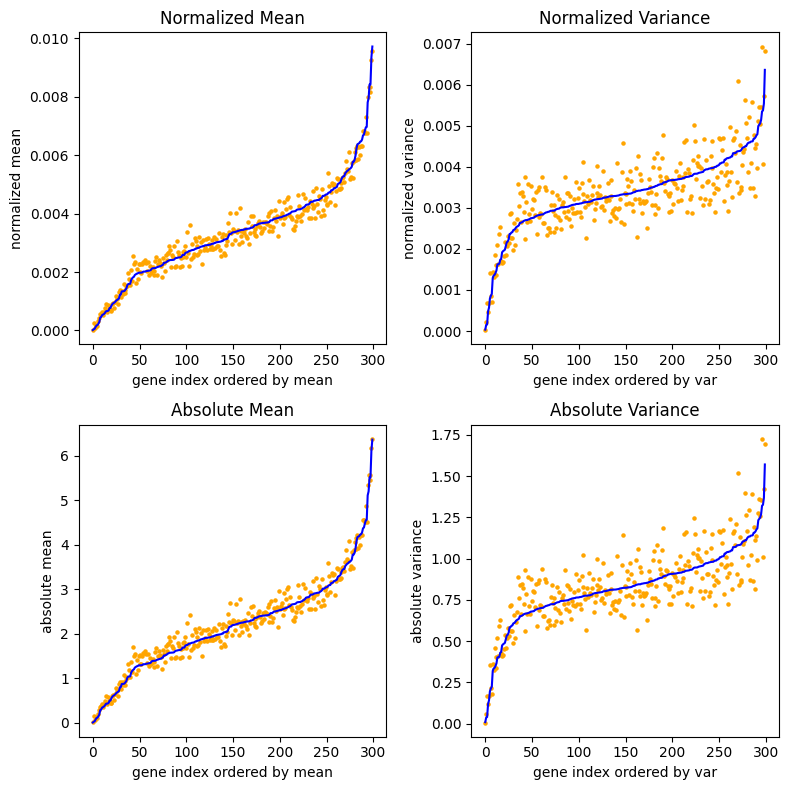

In [154]:
# gene variation curve
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

pred_mean = np.mean(pred_avg, axis=0)
pred_mean = pred_mean / np.sum(pred_mean)
gt_mean = np.mean(test_count_mtx_selected_genes, axis=0)
gt_mean = gt_mean / np.sum(gt_mean)
gt_mean_sorted = np.sort(gt_mean)
pred_mean_sorted = pred_mean[np.argsort(gt_mean)]
axs[0, 0].plot(np.arange(len(gt_mean_sorted)), gt_mean_sorted, label="Ground Truth", c="b")
axs[0, 0].scatter(np.arange(len(pred_mean_sorted)), pred_mean_sorted, s=5, label="Predicted", c="orange")
axs[0, 0].set_title("Normalized Mean")
axs[0, 0].set_xlabel("gene index ordered by mean")
axs[0, 0].set_ylabel("normalized mean")
# axs[0, 0].set_ylim()

pred_mean = np.mean(pred_avg, axis=0)
gt_mean = np.mean(test_count_mtx_selected_genes, axis=0)
gt_mean_sorted = np.sort(gt_mean)
pred_mean_sorted = pred_mean[np.argsort(gt_mean)]
axs[1, 0].plot(np.arange(len(gt_mean_sorted)), gt_mean_sorted, label="Ground Truth", c="b")
axs[1, 0].scatter(np.arange(len(pred_mean_sorted)), pred_mean_sorted, s=5, label="Predicted", c="orange")
axs[1, 0].set_title("Absolute Mean")
axs[1, 0].set_xlabel("gene index ordered by mean")
axs[1, 0].set_ylabel("absolute mean")
# axs[1, 0].set_ylim()


pred_var = np.var(pred_avg, axis=0)
pred_var = pred_var / np.sum(pred_var)
gt_var = np.var(test_count_mtx_selected_genes, axis=0)
gt_var = gt_var / np.sum(gt_var)
gt_var_sorted = np.sort(gt_var)
pred_var_sorted = pred_var[np.argsort(gt_var)]
axs[0, 1].plot(np.arange(len(gt_var_sorted)), gt_var_sorted, label="Ground Truth", c="b")
axs[0, 1].scatter(np.arange(len(pred_var_sorted)), pred_var_sorted, s=5, label="Predicted", c="orange")
axs[0, 1].set_title("Normalized Variance")
axs[0, 1].set_xlabel("gene index ordered by var")
axs[0, 1].set_ylabel("normalized variance")
# axs[0, 1].set_ylim()



pred_var = np.var(pred_avg, axis=0)
gt_var = np.var(test_count_mtx_selected_genes, axis=0)
gt_var_sorted = np.sort(gt_var)
pred_var_sorted = pred_var[np.argsort(gt_var)]
axs[1, 1].plot(np.arange(len(gt_var_sorted)), gt_var_sorted, label="Ground Truth", c="b")
axs[1, 1].scatter(np.arange(len(pred_var_sorted)), pred_var_sorted, s=5, label="Predicted", c="orange")
axs[1, 1].set_title("Absolute Variance")
axs[1, 1].set_xlabel("gene index ordered by var")
axs[1, 1].set_ylabel("absolute variance")
# axs[1, 1].set_ylim()

plt.tight_layout()
plt.show()

In [ ]:
# plot marker genes

Image.MAX_IMAGE_PIXELS = None

img_path = "./hest1k_datasets/PRAD/wsis/"
img_raw = Image.open(img_path + slide_out + ".tif") # change suffix according to image type

x = test_adata.obsm["spatial"][:, 0]
y = test_adata.obsm["spatial"][:, 1]
for gene in [""]: # fill in gene names
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    fig.suptitle(gene)
    gene_idx = np.where(np.array(selected_genes) == gene)[0][0]

    axs[0].imshow(img_raw)
    color_gt = test_adata[:, test_adata.var_names == gene].X.toarray().flatten()
    im0 = axs[0].scatter(x, y, c=color_gt, s=15, alpha=0.9)
    axs[0].set_title("ground truth")
    fig.colorbar(im0)
    
    axs[1].imshow(img_raw)
    color_pred = pred_avg[:, gene_idx]
    im1 = axs[1].scatter(x, y, c=color_pred, s=15, alpha=0.9) 
    axs[1].set_title("pred")
    fig.colorbar(im1)
    
    plt.show()